## Example workflow for simulating spike trains

Remember, this is a visual reference guide to the example workflow MATLAB code and is not intended to be run as is. Some of the code you will see here is particular to jupyter notebook or for the purpose of better visualization.  For example, you'll see `%plot -s` in front of a figure call from time to time. This is a magic function used to set the size of the figure in jupyter notebook, *not in matlab*! For a complete tutorial, please follow along and step through the example code in `GenerateSpikes.m`

genInhomogenousPoisson uses a deletion method for generating poisson spikes so it's quite fast but the way it's written was specified for the replay generative model and sort of hacky since we were going back and forth between position based and time based algorithms. (see pfmodel2 line 222) Anyways, here I'll show a simple example of how to use it (and if need be alter it) so that it can be used in other situations.

First, add the codebase functions to your path

In [8]:
warning('off','all') %only since its annoying otherwise
cd('/Users/youkitanaka/Documents/Github/vandermeerlab/code-matlab/shared'); %your own path for codebase
p = genpath(pwd);
addpath(p);

Let's specify an arbitrary rate function – for example, a sine wave – and plot it. 

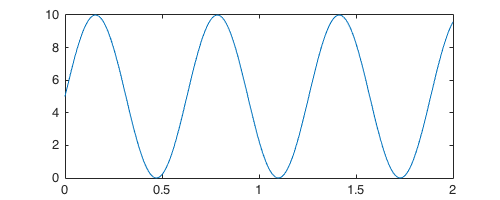

In [9]:
%plot -s 500,200
tvec = 0:.01:2; %some time vector
ratefunc = @(t) 5*sin(10*t)+5; %arbitrary sine wave

time_rate = ratefunc(tvec);
plot(tvec,time_rate)

Next, we need to specify the inputs into the function that generates spikes. These are the maximum firing rate, total elapsed time and the rate function we specified above. Now we can generate and plot spikes! 

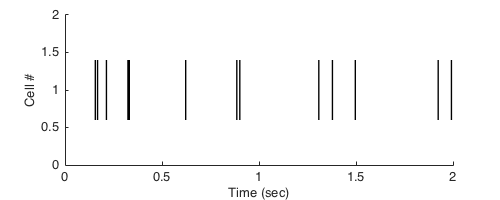

In [10]:
max_rate = max(time_rate); %get it from the rate function;
total_time = tvec(end)-tvec(1); %just get it from your tvec

% generate spikes
spiketimes = genInhomogeneousPoisson([],max_rate,total_time,ratefunc);
S = ts(spiketimes); %convert to ts struct for easy plotting

PlotSpikeRaster2([],S); 
axis([tvec(1),tvec(end),0,2]) %align axis with rate function

We can see that the spikes fall under the peaks of the firing rate plot above.

 ### Next steps


Now that we understand how to generate and plot spikes, let's try an example that follows the method SpikeGenerator.m uses to generate spike trains based on tuning curve and position input. As before, we first define a rate function.

In [11]:
% total_time needs to be a duration but it can be extracted from an interval...
t1 = 0.5;
t2 = 2.5;
total_time = t2-t1;

% define a gaussian function
ratefunc1 = @(x, a, b, c) a.*exp(-(x-b).^2/(2*(c.^2)));

ratefunc is gaussian function that returns a firing rate distribution where,   
x = 1-by-N position vector,   
a = gain of the firing rate (height of the curve),   
b = center of the peak,   
c = standard deviation (width of curve).   

Now let's simulate a 1-dimensional tuning curve by giving the rate function some position inputs. 

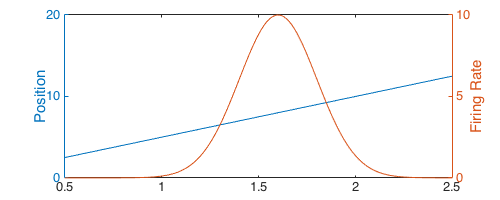

In [12]:
tvec = t1:.01:t2; % 
pvec = 5*tvec; % position moves at a constant speed of 5
center = 8; %center position of gaussian
std = 1; %width of gaussian
max_rate = 10; %peak of gaussian
pos_rate = ratefunc1(pvec,max_rate,center,std); %synthetic tuning curve

[ax,~,~] = plotyy(tvec,pvec,tvec,pos_rate);
axes(ax(1)); ylabel('Position');
axes(ax(2)); ylabel('Firing Rate');

In blue is the position as a function of time and red is the firing rate. We can see that there is a gaussian relationship between position and firing rate with the peak of the gaussian occuring when position = 8.

Let's now use this "tuning curve" and our position input to generate the correct input for `genInhomogenousPoisson`. That is, we need our rate function to be a function over time.

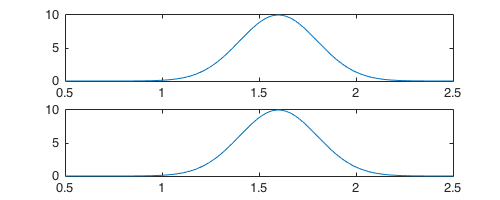

In [13]:
% We can our defined rate function for position using the gaussian function we defined...
ratefunc2 = @(t) ratefunc1(interp1(tvec,pvec,t),max_rate,center,std);

% or if you have a given position vector (e.g., position tsd) and a tuning curve, you can
% interpolate the rate at a given time
ratefunc3 = @(t) interp1(pvec,pos_rate,interp1(tvec,pvec,t));

% plot both methods for comparison
time_rate2 = ratefunc2(tvec); time_rate3 = ratefunc3(tvec);
subplot(211); plot(tvec,time_rate2);
subplot(212); plot(tvec,time_rate3);

Notice that there are multiple ways of defining the rate function! The method that `ratefunc3` uses is the one used in `SpikeGenerator.m` . This method uses empirical place field distributions and converts them into a time-based rate function. Now we can generate spikes like before.

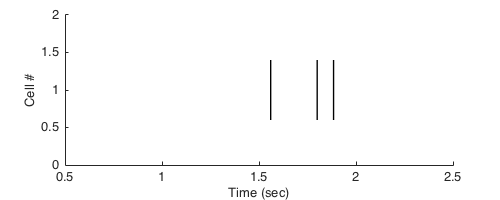

In [14]:
spiketimes = genInhomogeneousPoisson([],max_rate,total_time,ratefunc3);
S = ts(spiketimes); %convert to ts struct for easy plotting

PlotSpikeRaster2([],S); 
axis([0.5,2.5,0,2]) %align axis with rate function

### Congratulations! Now you know how to generate synthetic spiketrains!